In [25]:
import pandas as pd


import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords, wordnet

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score

In [3]:
reddit_data_df = pd.read_csv('../datasets/reddit_data_engineered.csv')

In [4]:
# reddit_data_df.set_index('id', inplace = True)

In [5]:

wn = WordNetLemmatizer()

In [6]:
## custom Tim funcion for mapping nltk POS_TAG for wordnet lemmatizing
def custom_lemmatize(word, tag):
    mapper = {
        'J': wordnet.ADJ,
        'V': wordnet.VERB,
        'N': wordnet.NOUN,
        'R': wordnet.ADV
    }
    pos = mapper.get(tag[0])
    
    return wn.lemmatize(word, pos) if pos else word

### Stem

In [7]:
# reddit_data_df['title'].apply(lambda title: [ps.stem(word) for word in title.split()])

### Lemmatize

In [8]:
reddit_data_df['title'] = reddit_data_df['title'].apply(lambda title : ' '.join([custom_lemmatize(word,tag) for word, tag in nltk.pos_tag(title.split())]))

In [9]:
# reddit_data_df['url_content_lem'] = reddit_data_df['url_content'].apply(lambda content : ' '.join([custom_lemmatize(word,tag) for word, tag in nltk.pos_tag(content.split())]))

In [10]:
reddit_data_df['subreddit'] = reddit_data_df['subreddit'].str.contains('Futurology').astype(int)

In [11]:
reddit_data_df.fillna('NA', inplace = True)

In [12]:
reddit_data_df.isnull().sum()

id                       0
type                     0
title                    0
self_text                0
subreddit                0
upvote_ratio             0
link_address             0
user                     0
datetime                 0
title_length_chars       0
title_length_words       0
title_avg_word_length    0
url_content              0
url_domain               0
external_link            0
dtype: int64

### Column transformer 

In [13]:
X = reddit_data_df.loc[: , ['title', 'title_avg_word_length', 'url_content', 'url_domain']]
X.shape

(3656, 4)

In [14]:
# X = reddit_data_df['title']

In [15]:
y = reddit_data_df['subreddit']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2023)

In [17]:
X_train.shape

(2742, 4)

In [18]:
y_train.shape

(2742,)

## Model 1 - Naive Bayes with Count Vectorizers

In [67]:
transformers = [
    ('title_vectorizer', CountVectorizer(binary= True, max_df = 0.9, min_df= 1, ngram_range=(1,1), stop_words=None), 'title'),
    ('url_content_vectorizer', CountVectorizer(binary = False, max_df=0.9, min_df=2, ngram_range=(2,2), stop_words='english'), 'url_content'),
    ('domain_one_hot', OneHotEncoder(drop='first', handle_unknown = 'ignore'), ['url_domain'])
]

In [68]:
pipe_nb = Pipeline([
    ('cvecs', ColumnTransformer(transformers, remainder = 'passthrough')),
    ('nb', MultinomialNB())
])

In [ ]:
# pgrid = {
#     'cvecs__title_vectorizer__stop_words' : [None], 
#     'cvecs__title_vectorizer__max_df' : [0.7, 0.8, 0.9], 
#     'cvecs__title_vectorizer__min_df' : [1, 2],
#     'cvecs__title_vectorizer__ngram_range': [(1,1)],
#     'cvecs__title_vectorizer__binary' : [False, True],
#     'cvecs__url_content_vectorizer__stop_words' : ['english'],
#     'cvecs__url_content_vectorizer__max_df' : [0.7, 0.8, 0.9],
#     'cvecs__url_content_vectorizer__min_df' : [1, 2, 3],
#     'cvecs__url_content_vectorizer__ngram_range': [(2,2)],
#     'cvecs__url_content_vectorizer__binary' : [False, True]
# }

## Model 2 - Naive Bayes with TFIDF Vectorizers

In [60]:
# transformers = [
#     ('title_vectorizer', TfidfVectorizer(max_df=0.6, max_features= None, min_df= 3, ngram_range=(1,2), stop_words='english'), 'title'),
#     ('url_content_vectorizer', TfidfVectorizer(max_df=0.7, min_df=4, ngram_range= (2,2)), 'url_content'),
#     ('domain_one_hot', OneHotEncoder(drop='first', handle_unknown = 'ignore'), ['url_domain'])
# ]

In [61]:
# pipe_nb = Pipeline([
#     ('tvecs', ColumnTransformer(transformers, remainder = 'passthrough')),
#     ('nb', MultinomialNB())
# ])

In [28]:
# pgrid = {
#     'tvecs__title_vectorizer__stop_words' : [None, 'english'], 
#     'tvecs__title_vectorizer__max_df' : [0.7, 0.8, 0.9], 
#     'tvecs__title_vectorizer__min_df' : [1, 2],
#     'tvecs__title_vectorizer__ngram_range': [(1,1), (1,2), (2,2)],
#     'tvecs__title_vectorizer__binary' : [False, True],
#     'tvecs__title_vectorizer__max_features' : [None, 2000, 3000],
#     'tvecs__url_content_vectorizer__stop_words' : [None, 'english'],
#     'tvecs__url_content_vectorizer__max_df' : [0.7, 0.8, 0.9, 0.95],
#     'tvecs__url_content_vectorizer__min_df' : [1, 2, 3],
#     'tvecs__url_content_vectorizer__ngram_range': [(1,1), (1,2), (2,2)],
#     'tvecs__url_content_vectorizer__binary' : [False, True]
# }

In [69]:
pipe_nb.fit(X_train, y_train)

Pipeline(steps=[('cvecs',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('title_vectorizer',
                                                  CountVectorizer(binary=True,
                                                                  max_df=0.9),
                                                  'title'),
                                                 ('url_content_vectorizer',
                                                  CountVectorizer(max_df=0.9,
                                                                  min_df=2,
                                                                  ngram_range=(2,
                                                                               2),
                                                                  stop_words='english'),
                                                  'url_content'),
                                                 ('domain_one_hot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['url_domain'])])),
                ('nb', MultinomialNB())])

In [70]:
pipe_nb.score(X_train, y_train)

0.9795769511305616

In [71]:
pipe_nb.score(X_test, y_test)

C:\Users\mikem\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:227: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0.9562363238512035

In [72]:
y_preds = pipe_nb.predict(X_test)

C:\Users\mikem\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:227: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


C:\Users\mikem\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:227: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


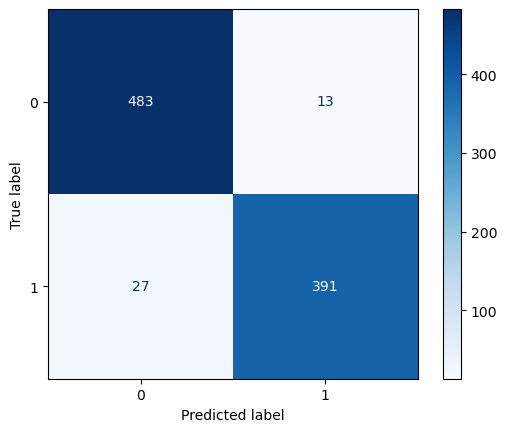

In [73]:
ConfusionMatrixDisplay.from_estimator(pipe_nb, X_test, y_test, cmap = 'Blues')

In [74]:
recall_score(y_test, y_preds)

0.9354066985645934

## Gridsearch

In [33]:
# gs = GridSearchCV(pipe_nb, pgrid, cv = 5, n_jobs = 12)

# %%time
# gs.fit(X_train, y_train)

# best_params = gs.best_params_

# best_params

In [ ]:
# gs.score(X_train, y_train)

In [1]:
# gs.score(X_test, y_test)

NameError: name 'gs' is not defined

C:\Users\mikem\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:227: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0.9354485776805251

In [328]:
y_preds = gs.predict(X_test)

C:\Users\mikem\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:227: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [329]:
confusion_matrix(y_test, y_preds)

array([[482,  14],
       [ 28, 390]], dtype=int64)

In [330]:
gs.best_params_

{'cvecs__title_vectorizer__binary': True,
 'cvecs__title_vectorizer__max_df': 0.7,
 'cvecs__title_vectorizer__min_df': 1,
 'cvecs__title_vectorizer__ngram_range': (1, 1),
 'cvecs__title_vectorizer__stop_words': None,
 'cvecs__url_content_vectorizer__binary': False,
 'cvecs__url_content_vectorizer__max_df': 0.7,
 'cvecs__url_content_vectorizer__min_df': 3,
 'cvecs__url_content_vectorizer__ngram_range': (2, 2),
 'cvecs__url_content_vectorizer__stop_words': 'english'}

In [265]:
1 - y.mean()

0.5363785557986871

C:\Users\mikem\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:227: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


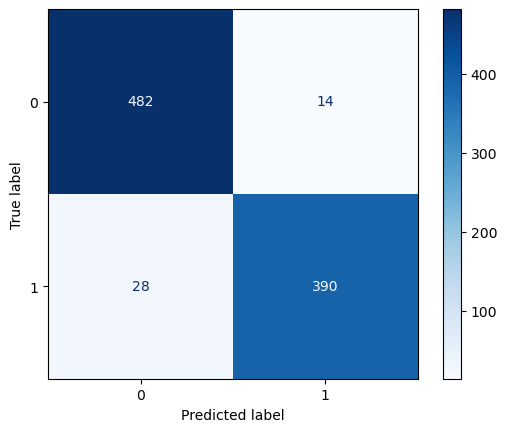

In [331]:
ConfusionMatrixDisplay.from_estimator(gs, X_test, y_test, cmap = 'Blues')

In [332]:
results = pd.DataFrame({
    'actually Futurology' : y_test,
    'predicted Futurology' : y_preds
})

In [333]:
false_positives = results[(results['actually Futurology'] == 0) & (results['predicted Futurology'] == 1)].index

In [335]:
false_positives

Int64Index([3300, 1766, 2489, 1878, 1995, 3451, 2422, 2813, 1791, 1804, 2215,
            3428, 3530, 2818],
           dtype='int64')

In [338]:
reddit_data_df.iloc[false_positives, :]

,id,type,title,self_text,subreddit,upvote_ratio,link_address,user,datetime,title_length_chars,title_length_words,title_avg_word_length,url_content,url_domain,external_link
3300,mpeykb,top,"In the 60s ""Astronaut happiness wasn’t a facto...",NA,0,0.97,https://www.supercluster.com/editorial/weekend...,EricFromOuterSpace,2021-04-12 10:25:35,300,52,5.769231,editorial weekends in space,supercluster.com,1
1766,178osme,hot,Ice 9,The end is near,0,0.79,https://www.sciencealert.com/strange-form-of-i...,SageCactus,2023-10-15 16:54:07,5,2,2.500000,strange form of ice found that only melts at e...,sciencealert.com,1
2489,16m2duk,hot,Future eyewear (@m0ds.lab instagram),NA,0,0.59,https://i.redd.it/wy7p2re2z1pb1.jpg,l0siento,2023-09-18 13:56:43,36,4,9.000000,NA,NA,0
1878,1754v2f,hot,Some of Shinji Aramaki’s production sketch fro...,NA,0,0.90,https://www.reddit.com/gallery/1754v2f,Chr0mo_Color,2023-10-10 23:48:37,66,9,7.333333,NA,NA,0
1995,172q9e7,hot,High as the moon,This was inspired by you guys 🙏🏿,0,0.23,https://i.redd.it/kgxctwvlqwsb1.jpg,Dependent_Shelter599,2023-10-08 00:36:56,16,4,4.000000,NA,NA,0
3451,zu9paw,top,A cleric fight against a system he once defend...,NA,0,0.97,https://v.redd.it/ta6xtev61w7a1,WildDog3000,2022-12-24 08:20:13,114,18,6.333333,ta6xtev61w7a1,v.redd.it,1
2422,16nno9q,hot,How to cause a global dark age?,"Pretty simple question, I wanna make a dystopi...",0,0.83,https://www.reddit.com/r/scifi/comments/16nno9...,GuestOk583,2023-09-20 11:08:38,31,7,4.428571,NA,NA,0
2813,zy34ug,top,"Why don't Na'vi have four arms, four eyes, two...",NA,0,0.91,https://i.redd.it/fird66vtnt8a1.png,Aetius_Flavius,2022-12-29 06:26:08,129,24,5.375000,NA,NA,0
1791,178i6oz,hot,If you be to get executed. Would you rather ge...,\n\n[View Poll](https://www.reddit.com/poll/17...,0,0.33,https://www.reddit.com/r/scifi/comments/178i6o...,dogtron64,2023-10-15 11:46:40,118,24,4.916667,NA,NA,0
1804,177s5ew,hot,LIVE coverage from NASA of the Solar Ecliipse ...,NA,0,0.63,https://www.youtube.com/watch?v=LlY79zjud-Q,badaimbadjokes,2023-10-14 11:32:32,73,13,5.615385,watch v=LlY79zjud Q,youtube.com,1


In [275]:
results[results['actually Futurology'] != results['predicted Futurology']]

,actually Futurology,predicted Futurology
id,,
mpeykb,0,1
166gns0,1,0
15qqpot,1,0
16i563y,1,0
15uiq28,1,0
16ar3u8,1,0
178osme,0,1
16m2duk,0,1
165yzac,1,0
